In [330]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import datetime as dt
import pyarrow.feather as feather

#Setup the figures to be higher DPI when displayed in the notebook and saved
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

#Determine if you want to save the figures or just display them in the notebook
save_figure_option = True
data_export = True

In [290]:
station_entries_df = pd.read_csv("data/CTA_Ridership_L_Station_Entries_Daily_Totals_20241112.csv")
station_entries_df.head(10)

,station_id,stationname,date,daytype,rides
0,41280,Jefferson Park,12/22/2017,W,6104
1,41000,Cermak-Chinatown,12/18/2017,W,3636
2,40280,Central-Lake,12/02/2017,A,1270
3,40140,Dempster-Skokie,12/19/2017,W,1759
4,40690,Dempster,12/03/2017,U,499
5,41660,Lake/State,12/30/2017,A,8615
6,40180,Oak Park-Forest Park,12/17/2017,U,442
7,40250,Kedzie-Homan-Forest Park,12/02/2017,A,1353
8,40120,35th/Archer,12/07/2017,W,3353
9,41420,Addison-North Main,12/19/2017,W,6034


In [291]:
station_entries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232735 entries, 0 to 1232734
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   station_id   1232735 non-null  int64 
 1   stationname  1232735 non-null  object
 2   date         1232735 non-null  object
 3   daytype      1232735 non-null  object
 4   rides        1232735 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 47.0+ MB


In [292]:
#Make categories out of the stations names and daytype
station_entries_df["stationname"] = station_entries_df["stationname"].astype("category")
station_entries_df["daytype"] = station_entries_df["daytype"].astype("category")
station_entries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232735 entries, 0 to 1232734
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype   
---  ------       --------------    -----   
 0   station_id   1232735 non-null  int64   
 1   stationname  1232735 non-null  category
 2   date         1232735 non-null  object  
 3   daytype      1232735 non-null  category
 4   rides        1232735 non-null  int64   
dtypes: category(2), int64(2), object(1)
memory usage: 31.7+ MB


In [293]:
#change date to a datetime object
station_entries_df["date"] = station_entries_df["date"].apply(lambda s: datetime.strptime(s, "%m/%d/%Y"))
station_entries_df.head()

,station_id,stationname,date,daytype,rides
0,41280,Jefferson Park,2017-12-22,W,6104
1,41000,Cermak-Chinatown,2017-12-18,W,3636
2,40280,Central-Lake,2017-12-02,A,1270
3,40140,Dempster-Skokie,2017-12-19,W,1759
4,40690,Dempster,2017-12-03,U,499


In [294]:
station_entries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232735 entries, 0 to 1232734
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   station_id   1232735 non-null  int64         
 1   stationname  1232735 non-null  category      
 2   date         1232735 non-null  datetime64[ns]
 3   daytype      1232735 non-null  category      
 4   rides        1232735 non-null  int64         
dtypes: category(2), datetime64[ns](1), int64(2)
memory usage: 31.7 MB


In [295]:
station_entries_df.describe()

,station_id,date,rides
count,1.232735e+06,1232735,1.232735e+06
mean,4.076793e+04,2012-11-11 05:14:51.254324224,2.979097e+03
min,4.001000e+04,2001-01-01 00:00:00,0.000000e+00
25%,4.037000e+04,2006-12-12 00:00:00,9.330000e+02
50%,4.076000e+04,2012-11-22 00:00:00,1.940000e+03
75%,4.116000e+04,2018-10-09 00:00:00,3.918000e+03
max,4.171000e+04,2024-08-31 00:00:00,3.632300e+04
std,4.499409e+02,NaN,3.061730e+03


In [296]:
len(station_entries_df[station_entries_df["rides"] == 0]) / len(station_entries_df["rides"]) * 100

1.2009880469038356

1.2% of the data is listed as having 0 rides and this can be for a variety of reasons, the most common being that the station is closed for work. For example, as part of the rpm (Red Purple Moderinization project) Berwyn and Lawerence have been closed for several years. Bryn Mawr was also closed for a few years and has only recently reopened but only with service in the direction of 95th. It would be challenging for a model to pick up on these trends without external data such as when long projects such as this are happening; hence, this data will be removed from the dataset. 

In [297]:
station_entries_df = station_entries_df.drop(station_entries_df[station_entries_df["rides"] == 0].index)
len(station_entries_df[station_entries_df["rides"] == 0]) #confirm the drop

0

In [298]:
len(set(station_entries_df["station_id"]))

148

In [299]:
len(set(station_entries_df["stationname"]))

149

Looks like the reason these set lengths do not match is becasue the Skokie Swift, now the yellow line, used to have its terminus station called Skokie versus its current name Dempster-Skokie, however the station id and location has not changed.

In [300]:
station_info_df = pd.read_csv("data/CTA_-_System_Information_-_List_of__L__Stops_20241211.csv")
station_info_df.head(10)

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,30082,E,Cicero (Loop-bound),Cicero,Cicero (Pink Line),40420,True,False,False,False,False,False,False,False,True,False,"(41.85182, -87.745336)"
1,30151,E,Central Park (Loop-bound),Central Park,Central Park (Pink Line),40780,True,False,False,False,False,False,False,False,True,False,"(41.853839, -87.714842)"
2,30184,W,Halsted/63rd (Ashland-bound),Halsted,Halsted (Green Line),40940,True,False,False,True,False,False,False,False,False,False,"(41.778943, -87.644244)"
3,30044,N,Cumberland (O'Hare-bound),Cumberland,Cumberland (Blue Line),40230,True,False,True,False,False,False,False,False,False,False,"(41.984246, -87.838028)"
4,30092,E,Racine (O'Hare-bound),Racine,Racine (Blue Line),40470,False,False,True,False,False,False,False,False,False,False,"(41.87592, -87.659458)"
5,30253,N,Paulina (Kimball-bound),Paulina,Paulina (Brown Line),41310,True,False,False,False,True,False,False,False,False,False,"(41.943623, -87.670907)"
6,30162,W,18th (54th/Cermak-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
7,30374,S,Clark/Lake (Forest Pk-bound),Clark/Lake,"Clark/Lake (Blue, Brown, Green, Orange, Purple...",40380,True,False,True,False,False,False,False,False,False,False,"(41.885737, -87.630886)"
8,30248,S,Jefferson Park (Forest Pk-bound),Jefferson Park,Jefferson Park (Blue Line),41280,True,False,True,False,False,False,False,False,False,False,"(41.970634, -87.760892)"
9,30104,S,Diversey (Loop-bound),Diversey,Diversey (Brown & Purple lines),40530,True,False,False,False,True,False,True,False,False,False,"(41.932732, -87.653131)"


In [301]:
station_info_df[station_info_df["STATION_NAME"] == "Addison"]

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
47,30239,N,Addison (O'Hare-bound),Addison,Addison (Blue Line),41240,True,False,True,False,False,False,False,False,False,False,"(41.94738, -87.71906)"
82,30240,S,Addison (Forest Pk-bound),Addison,Addison (Blue Line),41240,True,False,True,False,False,False,False,False,False,False,"(41.94738, -87.71906)"
92,30274,S,Addison (95th-bound),Addison,Addison (Red Line),41420,True,True,False,False,False,False,False,False,False,False,"(41.947428, -87.653626)"
130,30273,N,Addison (Howard-bound),Addison,Addison (Red Line),41420,True,True,False,False,False,False,False,False,False,False,"(41.947428, -87.653626)"
221,30278,S,Addison (Loop-bound),Addison,Addison (Brown Line),41440,True,False,False,False,True,False,False,False,False,False,"(41.947028, -87.674642)"
262,30277,N,Addison (Kimball-bound),Addison,Addison (Brown Line),41440,True,False,False,False,True,False,False,False,False,False,"(41.947028, -87.674642)"


The CTA does provide a helpful file which has information on each station and after a bit of exlploring MAP_ID in this station information file corresponds to the station_id in the station entries file. Hence, this is how we will join these two datasets. However, before doing that, we will explore a single stations' ridership totals to see if there is anything we will need to be aware of before we do more cleaning. State/Lake is considered the epicenter of the Loop and all train lines except red, blue and yellow visit this station so it's the one we will plot. 

In [302]:
station_info_df = station_info_df.rename(columns={"MAP_ID":"station_id"})
station_info_df.head()

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,station_id,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,30082,E,Cicero (Loop-bound),Cicero,Cicero (Pink Line),40420,True,False,False,False,False,False,False,False,True,False,"(41.85182, -87.745336)"
1,30151,E,Central Park (Loop-bound),Central Park,Central Park (Pink Line),40780,True,False,False,False,False,False,False,False,True,False,"(41.853839, -87.714842)"
2,30184,W,Halsted/63rd (Ashland-bound),Halsted,Halsted (Green Line),40940,True,False,False,True,False,False,False,False,False,False,"(41.778943, -87.644244)"
3,30044,N,Cumberland (O'Hare-bound),Cumberland,Cumberland (Blue Line),40230,True,False,True,False,False,False,False,False,False,False,"(41.984246, -87.838028)"
4,30092,E,Racine (O'Hare-bound),Racine,Racine (Blue Line),40470,False,False,True,False,False,False,False,False,False,False,"(41.87592, -87.659458)"


In [303]:
station_info_df = station_info_df.drop("STATION_DESCRIPTIVE_NAME", axis=1)

In [304]:
station_entries_df = station_entries_df.drop("stationname", axis=1)

In [305]:
merged_station_entries_df = pd.merge(station_entries_df, station_info_df, on="station_id", how="left")
merged_station_entries_df.head(10)

,station_id,date,daytype,rides,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,41280,2017-12-22,W,6104,30248.0,S,Jefferson Park (Forest Pk-bound),Jefferson Park,True,False,True,False,False,False,False,False,False,False,"(41.970634, -87.760892)"
1,41280,2017-12-22,W,6104,30247.0,N,Jefferson Park (O'Hare-bound),Jefferson Park,True,False,True,False,False,False,False,False,False,False,"(41.970634, -87.760892)"
2,41000,2017-12-18,W,3636,30193.0,N,Cermak-Chinatown (Howard-bound),Cermak-Chinatown,True,True,False,False,False,False,False,False,False,False,"(41.853206, -87.630968)"
3,41000,2017-12-18,W,3636,30194.0,S,Cermak-Chinatown (95th-bound),Cermak-Chinatown,True,True,False,False,False,False,False,False,False,False,"(41.853206, -87.630968)"
4,40280,2017-12-02,A,1270,30054.0,E,Central (63rd-bound),Central,True,False,False,True,False,False,False,False,False,False,"(41.887389, -87.76565)"
5,40280,2017-12-02,A,1270,30055.0,W,Central (Harlem-bound),Central,True,False,False,True,False,False,False,False,False,False,"(41.887389, -87.76565)"
6,40140,2017-12-19,W,1759,30027.0,S,Dempster-Skokie (Howard-bound),Dempster-Skokie,True,False,False,False,False,False,False,True,False,False,"(42.038951, -87.751919)"
7,40140,2017-12-19,W,1759,30026.0,N,Dempster-Skokie (Arrival),Dempster-Skokie,True,False,False,False,False,False,False,True,False,False,"(42.038951, -87.751919)"
8,40690,2017-12-03,U,499,30134.0,S,Dempster (Howard-Loop-bound),Dempster,False,False,False,False,False,True,True,False,False,False,"(42.041655, -87.681602)"
9,40690,2017-12-03,U,499,30133.0,N,Dempster (Linden-bound),Dempster,False,False,False,False,False,True,True,False,False,False,"(42.041655, -87.681602)"


A bit more cleanup to make things easier for modeling and for humans to read / understand

In [306]:
#Rename the line abbreviations to their actual colors or as express as appropriate 
merged_station_entries_df = merged_station_entries_df.rename(columns={"G":"GREEN", "BRN": "BROWN", "P":"PURPLE", "Pexp":"PURPLE EXPRESS", "Y":"YELLOW", "Pnk":"PINK", "O":"ORANGE"})

In [307]:
#Separate out the location column into lat and long
merged_station_entries_df[["latitude", "longitude"]] = merged_station_entries_df["Location"].str.strip("()").str.split(",", expand=True)
merged_station_entries_df = merged_station_entries_df.drop("Location", axis=1)
merged_station_entries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2543466 entries, 0 to 2543465
Data columns (total 20 columns):
 #   Column          Dtype         
---  ------          -----         
 0   station_id      int64         
 1   date            datetime64[ns]
 2   daytype         category      
 3   rides           int64         
 4   STOP_ID         float64       
 5   DIRECTION_ID    object        
 6   STOP_NAME       object        
 7   STATION_NAME    object        
 8   ADA             object        
 9   RED             object        
 10  BLUE            object        
 11  GREEN           object        
 12  BROWN           object        
 13  PURPLE          object        
 14  PURPLE EXPRESS  object        
 15  YELLOW          object        
 16  PINK            object        
 17  ORANGE          object        
 18  latitude        object        
 19  longitude       object        
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(15)
memory usage: 371.1+ M

In [308]:
merged_station_entries_df.head()

,station_id,date,daytype,rides,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,ADA,RED,BLUE,GREEN,BROWN,PURPLE,PURPLE EXPRESS,YELLOW,PINK,ORANGE,latitude,longitude
0,41280,2017-12-22,W,6104,30248.0,S,Jefferson Park (Forest Pk-bound),Jefferson Park,True,False,True,False,False,False,False,False,False,False,41.970634,-87.760892
1,41280,2017-12-22,W,6104,30247.0,N,Jefferson Park (O'Hare-bound),Jefferson Park,True,False,True,False,False,False,False,False,False,False,41.970634,-87.760892
2,41000,2017-12-18,W,3636,30193.0,N,Cermak-Chinatown (Howard-bound),Cermak-Chinatown,True,True,False,False,False,False,False,False,False,False,41.853206,-87.630968
3,41000,2017-12-18,W,3636,30194.0,S,Cermak-Chinatown (95th-bound),Cermak-Chinatown,True,True,False,False,False,False,False,False,False,False,41.853206,-87.630968
4,40280,2017-12-02,A,1270,30054.0,E,Central (63rd-bound),Central,True,False,False,True,False,False,False,False,False,False,41.887389,-87.76565


In [309]:
#Stop ID
merged_station_entries_df["STOP_ID"] = merged_station_entries_df["STOP_ID"].astype("category")
#Direction ID
merged_station_entries_df["DIRECTION_ID"] = merged_station_entries_df["DIRECTION_ID"].astype("category")
#Stop Name
merged_station_entries_df["STOP_NAME"] = merged_station_entries_df["STOP_NAME"].astype("category")
#Station Name
merged_station_entries_df["STATION_NAME"] = merged_station_entries_df["STATION_NAME"].astype("category")
#ADA
merged_station_entries_df["ADA"] = merged_station_entries_df["ADA"].astype("bool")
#Red
merged_station_entries_df["RED"] = merged_station_entries_df["RED"].astype("bool")
#Blue
merged_station_entries_df["BLUE"] = merged_station_entries_df["BLUE"].astype("bool")
#Green
merged_station_entries_df["GREEN"] = merged_station_entries_df["GREEN"].astype("bool")
#Brown
merged_station_entries_df["BROWN"] = merged_station_entries_df["BROWN"].astype("bool")
#Purple
merged_station_entries_df["PURPLE"] = merged_station_entries_df["PURPLE"].astype("bool")
#Purple Express
merged_station_entries_df["PURPLE EXPRESS"] = merged_station_entries_df["PURPLE EXPRESS"].astype("bool")
#Yellow
merged_station_entries_df["YELLOW"] = merged_station_entries_df["YELLOW"].astype("bool")
#Pink
merged_station_entries_df["PINK"] = merged_station_entries_df["PINK"].astype("bool")
#Orange
merged_station_entries_df["ORANGE"] = merged_station_entries_df["ORANGE"].astype("bool")
#latitude
merged_station_entries_df["latitude"] = merged_station_entries_df["latitude"].astype("float")
#longitude
merged_station_entries_df["longitude"] = merged_station_entries_df["longitude"].astype("float")
merged_station_entries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2543466 entries, 0 to 2543465
Data columns (total 20 columns):
 #   Column          Dtype         
---  ------          -----         
 0   station_id      int64         
 1   date            datetime64[ns]
 2   daytype         category      
 3   rides           int64         
 4   STOP_ID         category      
 5   DIRECTION_ID    category      
 6   STOP_NAME       category      
 7   STATION_NAME    category      
 8   ADA             bool          
 9   RED             bool          
 10  BLUE            bool          
 11  GREEN           bool          
 12  BROWN           bool          
 13  PURPLE          bool          
 14  PURPLE EXPRESS  bool          
 15  YELLOW          bool          
 16  PINK            bool          
 17  ORANGE          bool          
 18  latitude        float64       
 19  longitude       float64       
dtypes: bool(10), category(5), datetime64[ns](1), float64(2), int64(2)
memory usage: 138.3 MB


In [310]:
merged_station_entries_df.head()

,station_id,date,daytype,rides,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,ADA,RED,BLUE,GREEN,BROWN,PURPLE,PURPLE EXPRESS,YELLOW,PINK,ORANGE,latitude,longitude
0,41280,2017-12-22,W,6104,30248.0,S,Jefferson Park (Forest Pk-bound),Jefferson Park,True,False,True,False,False,False,False,False,False,False,41.970634,-87.760892
1,41280,2017-12-22,W,6104,30247.0,N,Jefferson Park (O'Hare-bound),Jefferson Park,True,False,True,False,False,False,False,False,False,False,41.970634,-87.760892
2,41000,2017-12-18,W,3636,30193.0,N,Cermak-Chinatown (Howard-bound),Cermak-Chinatown,True,True,False,False,False,False,False,False,False,False,41.853206,-87.630968
3,41000,2017-12-18,W,3636,30194.0,S,Cermak-Chinatown (95th-bound),Cermak-Chinatown,True,True,False,False,False,False,False,False,False,False,41.853206,-87.630968
4,40280,2017-12-02,A,1270,30054.0,E,Central (63rd-bound),Central,True,False,False,True,False,False,False,False,False,False,41.887389,-87.765650


Now that we have cleaned up the ridership data and added the useful station information from the CTA's L station information dataset, we can split the data by station ID. This is done, since it is more meaningful to predict ridership by station than attempt to predict all stations for a given day. The stakeholders having knowledge of the ridership at each station will help improve schedules and estimate system capacity and usage overall versus only having predicted totals per day which will only provide useful information on system capacity as a whole. 

In [311]:
#station ID array
stations = np.array(list(set(merged_station_entries_df["station_id"])))
#Create a dictionary of DataFrames with each entry being the data for one station
station_entries_dfs = {station_id: data for station_id, data in merged_station_entries_df.groupby("station_id")}

In [312]:
len(stations)

148

In [313]:
station_entries_dfs[int(stations[147])]

,station_id,date,daytype,rides,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,ADA,RED,BLUE,GREEN,BROWN,PURPLE,PURPLE EXPRESS,YELLOW,PINK,ORANGE,latitude,longitude
290,40440,2017-12-02,A,841,30086.0,E,California (Loop-bound),California,True,False,False,False,False,False,False,False,True,False,41.854109,-87.694774
291,40440,2017-12-02,A,841,30087.0,W,California (54th/Cermak-bound),California,True,False,False,False,False,False,False,False,True,False,41.854109,-87.694774
618,40440,2017-12-18,W,1337,30086.0,E,California (Loop-bound),California,True,False,False,False,False,False,False,False,True,False,41.854109,-87.694774
619,40440,2017-12-18,W,1337,30087.0,W,California (54th/Cermak-bound),California,True,False,False,False,False,False,False,False,True,False,41.854109,-87.694774
1066,40440,2017-12-27,W,848,30086.0,E,California (Loop-bound),California,True,False,False,False,False,False,False,False,True,False,41.854109,-87.694774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2536827,40440,2024-08-29,W,1163,30087.0,W,California (54th/Cermak-bound),California,True,False,False,False,False,False,False,False,True,False,41.854109,-87.694774
2536828,40440,2024-08-30,W,1120,30086.0,E,California (Loop-bound),California,True,False,False,False,False,False,False,False,True,False,41.854109,-87.694774
2536829,40440,2024-08-30,W,1120,30087.0,W,California (54th/Cermak-bound),California,True,False,False,False,False,False,False,False,True,False,41.854109,-87.694774
2536830,40440,2024-08-31,A,730,30086.0,E,California (Loop-bound),California,True,False,False,False,False,False,False,False,True,False,41.854109,-87.694774


In [314]:
#Organize the dataframes (sort by date and reset the indicies)
for station_id, station_entry_df in station_entries_dfs.items():
    station_entry_df.sort_values(by="date", ascending=False, inplace=True)
    station_entry_df.reset_index(drop=True, inplace=True)

There are some station IDs that have evolved over the years and are no longer in service today nor during the dates we will be modeling against; hence, these stations will be dropped.

In [315]:
del station_entries_dfs[40500]
del station_entries_dfs[41580]
del station_entries_dfs[40640]
del station_entries_dfs[40200]

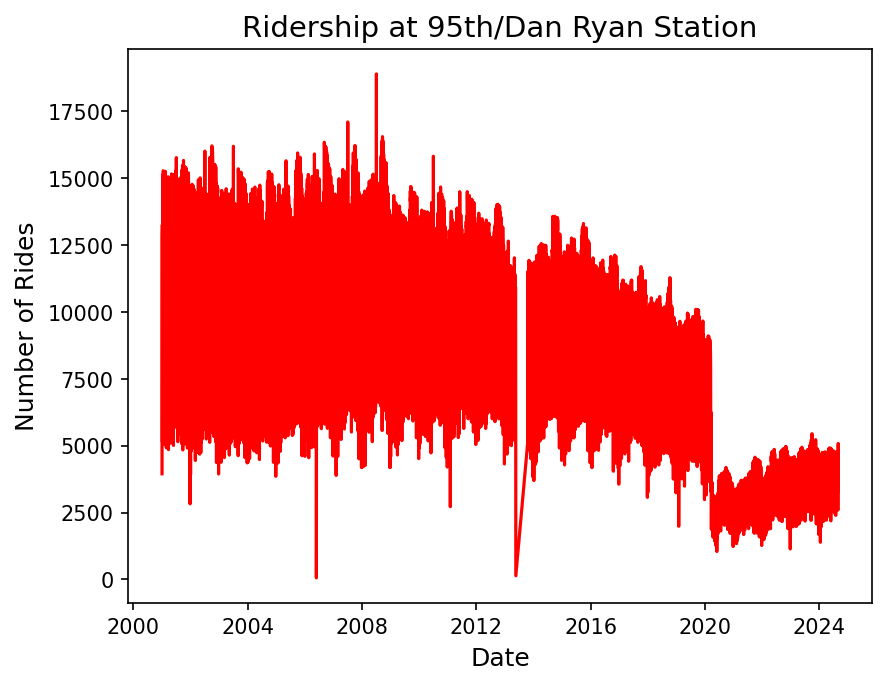

In [316]:
fig, ax = plt.subplots()
sns.lineplot(data=station_entries_dfs[int(stations[1])], x="date", y="rides", color="red", ax=ax)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Rides", fontsize=12)
plt.title("Ridership at 95th/Dan Ryan Station", fontsize=14)
if save_figure_option:
    plt.savefig('figures/red_95th_station.png', bbox_inches='tight')
plt.show()

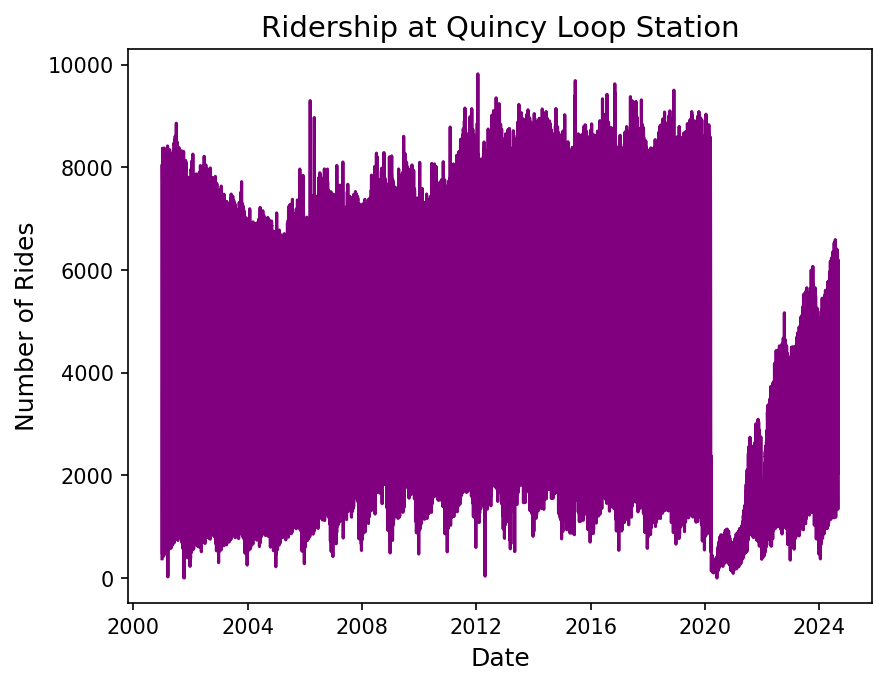

In [317]:
fig, ax = plt.subplots()
sns.lineplot(data=station_entries_dfs[40040], x="date", y="rides", color="purple", ax=ax)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Rides", fontsize=12)
plt.title("Ridership at Quincy Loop Station", fontsize=14)
if save_figure_option:
    plt.savefig('figures/quincy_station.png', bbox_inches='tight')
plt.show()

In [318]:
#Check the logic for getting out just the data from 2017 to the latest point avaliable
temp_df = station_entries_dfs[40040][station_entries_dfs[40040]["date"].dt.date >= dt.date(2017,1,1)].copy()

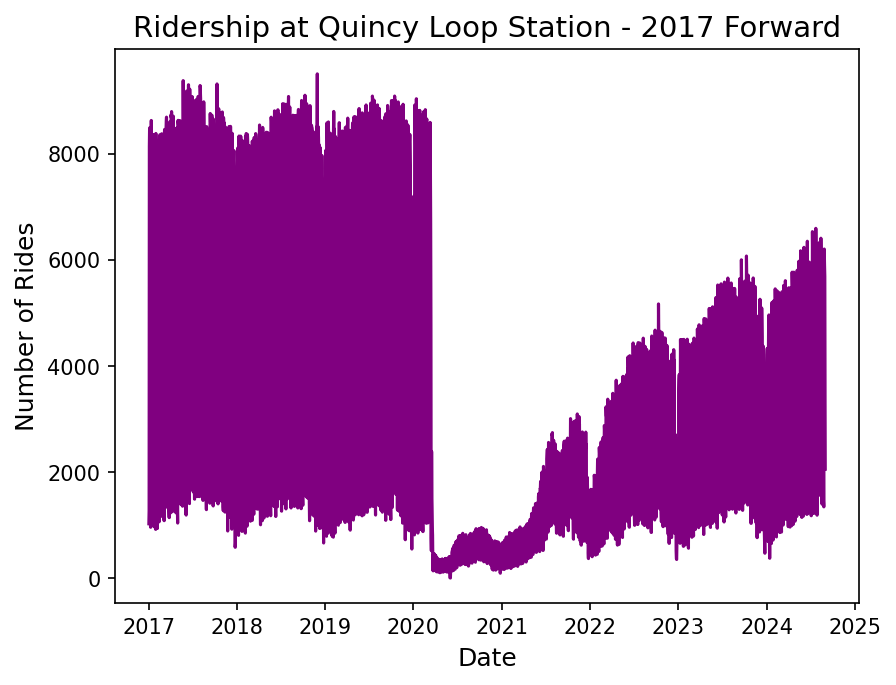

In [319]:
fig, ax = plt.subplots()

sns.lineplot(data=temp_df, x="date", y="rides", color="purple", ax=ax)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Rides", fontsize=12)
plt.title("Ridership at Quincy Loop Station - 2017 Forward", fontsize=14)
if save_figure_option:
    plt.savefig('figures/quincy_station_2017_2024.png', bbox_inches='tight')
plt.show()

## Trend Test
Now that we have isolated the data we care about we will use the scipy library to create a simple linear regression model and test if there is a statistically significant trend in the data

In [320]:
#Grab elapsed days from timedelta
first_date = temp_df["date"][len(temp_df)-1]
temp_df["elapsed_days"] = temp_df["date"].apply(lambda d: (d - first_date).days)
temp_df.head()

,station_id,date,daytype,rides,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,ADA,RED,...,GREEN,BROWN,PURPLE,PURPLE EXPRESS,YELLOW,PINK,ORANGE,latitude,longitude,elapsed_days
0,40040,2024-08-31,A,2050,30007.0,N,Quincy/Wells (Inner Loop),Quincy/Wells,True,False,...,False,False,False,True,False,True,True,41.878723,-87.63374,2799
1,40040,2024-08-31,A,2050,30008.0,S,Quincy/Wells (Outer Loop),Quincy/Wells,True,False,...,False,True,False,False,False,False,False,41.878723,-87.63374,2799
2,40040,2024-08-30,W,3288,30008.0,S,Quincy/Wells (Outer Loop),Quincy/Wells,True,False,...,False,True,False,False,False,False,False,41.878723,-87.63374,2798
3,40040,2024-08-30,W,3288,30007.0,N,Quincy/Wells (Inner Loop),Quincy/Wells,True,False,...,False,False,False,True,False,True,True,41.878723,-87.63374,2798
4,40040,2024-08-29,W,5686,30007.0,N,Quincy/Wells (Inner Loop),Quincy/Wells,True,False,...,False,False,False,True,False,True,True,41.878723,-87.63374,2797


In [321]:
result = stats.linregress(temp_df["elapsed_days"], temp_df["rides"])
print("Slope: " + str(result.slope))
print("R Value: " + str(result.rvalue))
print("p-value: " + str(result.pvalue))

predictions = temp_df["elapsed_days"] * result.slope + result.intercept
temp_df["prediction"] = predictions

Slope: -1.5233210455723256
R Value: -0.40208130585052837
p-value: 1.378358760672778e-216


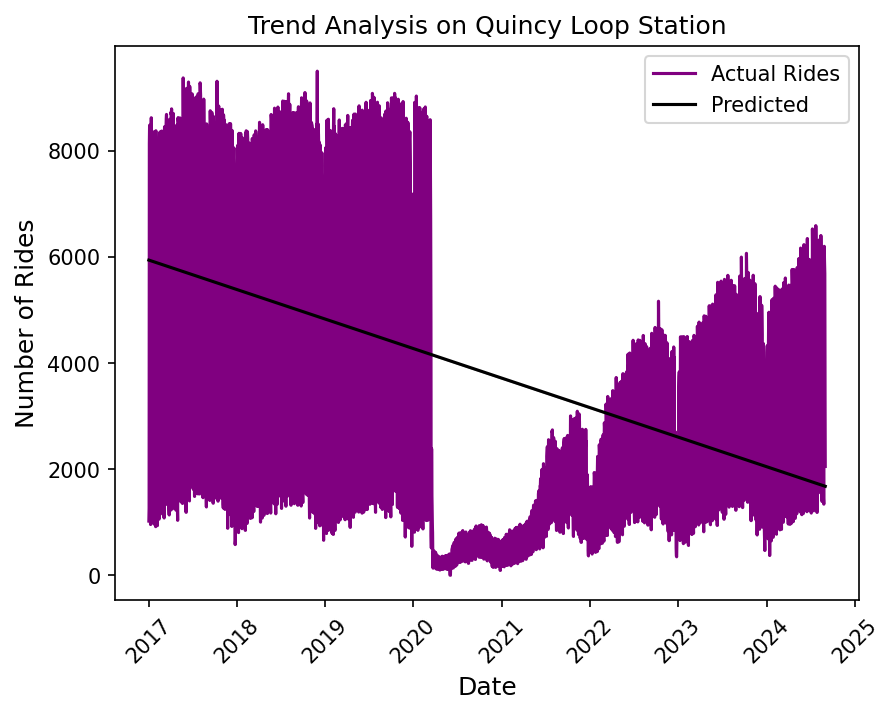

In [322]:
fig, ax = plt.subplots()

sns.lineplot(data=temp_df, x="date", y="rides", label="Actual Rides", color="purple", ax=ax)
sns.lineplot(data=temp_df, x="date", y="prediction", label="Predicted", color="black", ax=ax)
plt.xticks(rotation=45)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Rides", fontsize=12)
plt.title("Trend Analysis on Quincy Loop Station")
plt.legend()
if save_figure_option:
    plt.savefig('figures/trend_test_plot_quincy.png', bbox_inches='tight')
plt.show()

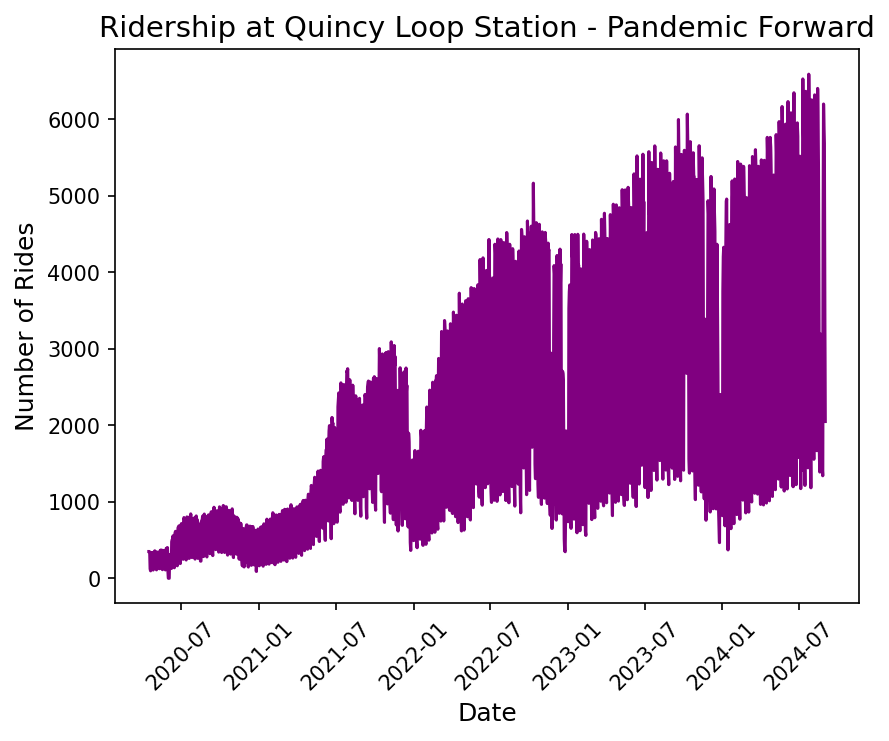

In [327]:
trend_test_2_df = temp_df[temp_df["date"].dt.date >= dt.date(2020,4,15)].copy()

fig, ax = plt.subplots()

sns.lineplot(data=trend_test_2_df, x="date", y="rides", color="purple", ax=ax)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Rides", fontsize=12)
plt.xticks(rotation=45)
plt.title("Ridership at Quincy Loop Station - Pandemic Forward", fontsize=14)
if save_figure_option:
    plt.savefig('figures/quincy_station_2020_2024.png', bbox_inches='tight')
plt.show()

In [328]:
#Grab elapsed days from timedelta
first_date = trend_test_2_df["date"][len(trend_test_2_df)-1]
trend_test_2_df["elapsed_days"] = trend_test_2_df["date"].apply(lambda d: (d - first_date).days)

result = stats.linregress(trend_test_2_df["elapsed_days"], trend_test_2_df["rides"])
print("Slope: " + str(result.slope))
print("R Value: " + str(result.rvalue))
print("p-value: " + str(result.pvalue))

predictions = trend_test_2_df["elapsed_days"] * result.slope + result.intercept
temp_df["prediction"] = predictions

Slope: 2.3836151492438815
R Value: 0.6613513165217091
p-value: 0.0


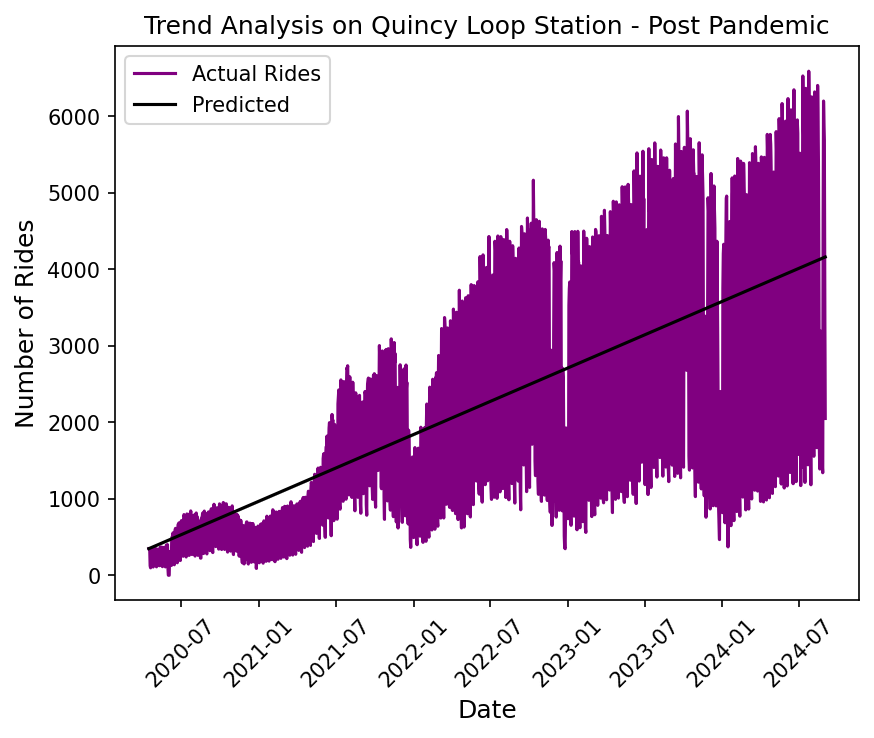

In [329]:
fig, ax = plt.subplots()

sns.lineplot(data=trend_test_2_df, x="date", y="rides", label="Actual Rides", color="purple", ax=ax)
sns.lineplot(data=trend_test_2_df, x="date", y="prediction", label="Predicted", color="black", ax=ax)
plt.xticks(rotation=45)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Rides", fontsize=12)
plt.title("Trend Analysis on Quincy Loop Station - Post Pandemic")
plt.legend()
if save_figure_option:
    plt.savefig('figures/trend_test_plot_quincy_post_pandemic.png', bbox_inches='tight')
plt.show()

## Data Export
This section will export each station's data as a feather file so it can be easily used in future notebooks throughout this project

In [331]:
if data_export:
    station_id_list = []
    station_name_list = []
    for station_id, station_entry_df in station_entries_dfs.items():
        station_id_list.append(station_id)
        station_name_list.append(station_entry_df["STATION_NAME"][0])
        path_1 = "data/feathers/" + str(station_id) + "_station_entries_2017_2024"
        path_2 = "data/feathers/" + str(station_id) + "_station_entries_2020_2024"
        temp_17_24_df = station_entry_df[station_entry_df["date"].dt.date >= dt.date(2017,1,1)].copy()
        temp_20_24_df = station_entry_df[station_entry_df["date"].dt.date >= dt.date(2020,4,15)].copy()
        feather.write_feather(temp_17_24_df, path_1)
        feather.write_feather(temp_20_24_df, path_2)
    #export a list of the station IDs for ease of use in future modeling and notebooks
    export_station_info_df = pd.DataFrame({"station_id": station_id_list, "station_name": station_name_list})
    export_station_info_df.to_csv("data/station_id_information.csv", index=False)
else:
    print("Data NOT Exported")